# Investigation of Appointment Absences

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#cleaning">Data Cleaning</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

>This report will investigate related causes for patient absenteeism using a large-sample dataset from Brazil 2016. This report will not utilize any regression analyses and will therefore be unable to provide any concrete relationships. Instead, this report will give approximations using graphical displays; graphics will include bar charts, histograms, and scatterplots. The primary characteristics investigated will be as follows: gender, appointment day, and age. This report acknowledges that there may be significant omitted variable bias either due to unobservable or unmeasured characterics; most notably "culture" may be an unobservable/unmeasurable characteristic that might cause significant error.

>Data Source: Kaggle.com

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline

### General Properties

In [2]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB
None


>An info() method reveals that there are no missing values.

In [4]:
print(list(df.duplicated()).count(True))

0


>There are no duplicated values

In [5]:
print(df.describe())

          PatientId  AppointmentID            Age    Scholarship  \
count  1.105270e+05   1.105270e+05  110527.000000  110527.000000   
mean   1.474963e+14   5.675305e+06      37.088874       0.098266   
std    2.560949e+14   7.129575e+04      23.110205       0.297675   
min    3.921784e+04   5.030230e+06      -1.000000       0.000000   
25%    4.172614e+12   5.640286e+06      18.000000       0.000000   
50%    3.173184e+13   5.680573e+06      37.000000       0.000000   
75%    9.439172e+13   5.725524e+06      55.000000       0.000000   
max    9.999816e+14   5.790484e+06     115.000000       1.000000   

        Hipertension       Diabetes     Alcoholism        Handcap  \
count  110527.000000  110527.000000  110527.000000  110527.000000   
mean        0.197246       0.071865       0.030400       0.022248   
std         0.397921       0.258265       0.171686       0.161543   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       

>From an initial description of the data set it is apparent that the dataset is not yet suitable for analysis. There are a number of categories that are unwanted for the analysis (although still quite useful) and certain categories of interest, such as appointment day and no_show, would be graphed more easily after being transformed. For instance, the investigated, dependent variable -- no_show -- and the variable gender are both still in string form, when a binary form might be preferrable.

<a id='cleaning'></a>
### Data Cleaning
<ul>
    Check data set for missing values, check for duplicate values, and recode and rename certain characteristics.

>First, unwanted characteristics are dropped.

In [6]:
df.drop(['Neighbourhood', 'PatientId', 'ScheduledDay', 'AppointmentID', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received'], axis = 1, inplace = True)

>Second, targeted characteristics are renamed and recoded. For instance, gender and no_show will be replaced with a binary representation

In [7]:
df.rename(index = str, columns = lambda x: x.lower().replace('-', '_'), inplace = True)
df.replace(['M', 'F'], [0, 1], inplace = True)
# 0: Patient is male 1: Patient is female
df.replace(['No', 'Yes'], [0, 1], inplace = True)
# 0: Patient showed up 1: Patient was absent

In [8]:
print('The number of unique age values is: ', df['age'].nunique())

The number of unique age values is:  104


>A nunique() method reveals that there are 104 different age values. Althought his can still be graphed, binning the age values in a way that represents lifestage may also reveal different information.

In [9]:
# Obtaining Max and Min
youngest = df['age'].min()
eldest = df['age'].max()
#Binning age by approximate lifestages
bin_edges = [youngest, 13, 20, 35, 65, eldest]
bin_labels = ['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']
df['life_stage'] = pd.cut(df['age'], bin_edges, labels = bin_labels)
print(df['age'].head(10), df['life_stage'].head(10))

0    62
1    56
2    62
3     8
4    56
5    76
6    23
7    39
8    21
9    19
Name: age, dtype: int64 0          Adult
1          Adult
2          Adult
3          Child
4          Adult
5         Senior
6    Young Adult
7          Adult
8    Young Adult
9       Teenager
Name: life_stage, dtype: category
Categories (5, object): [Child < Teenager < Young Adult < Adult < Senior]


In [10]:
print('The number of appointment days is: ', df['appointmentday'].nunique())

The number of appointment days is:  27


>A unique() and nunique() command reveal that the all the patients in this sample had appointment days that spanned 27 different days, or roughly one month. Since all the days follow the same format, year-month-dayT00:00:00Z and all of them have the same year and time, it would be best to trim off that unneccesary information.

In [11]:
#trimming appointment dates
df['appt_trim'] = df['appointmentday'].str.slice(6, 10)

>Since every date instance has the same year and tail, the year and tail provide no additional information and should be trimmed.


<a id='eda'></a>
## Exploratory Data Analysis

In [12]:
# Dataset masks for present and absent patients.
present = df.no_show == 0
absent = df.no_show == 1
# Objects to be used for creating proportions
total = df.shape[0]
num_present = list(present).count(True)
num_absent = list(absent).count(True)
print(df['no_show'].describe())

count    110527.000000
mean          0.201933
std           0.401444
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: no_show, dtype: float64


>Given that 1 is equivalant to an absence, a mean summation provides the proportion of absenteeism throughout the entire database; 20% with a standard deviation of 40%. However this observed metric is not very useful due to the wide range of variance. The next step is to analyze this 20% and possibly define characteristics that are most likely to lead to absenteeism.

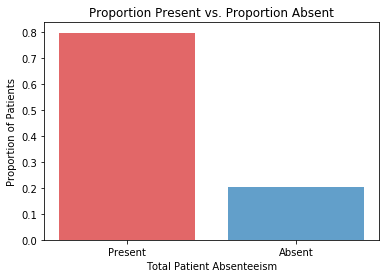

In [13]:
plt.bar(['Present', 'Absent'], [num_present/total, num_absent/total], color = ['C3', 'C0'], alpha = .7)
plt.xlabel('Total Patient Absenteeism')
plt.ylabel('Proportion of Patients')
plt.title('Proportion Present vs. Proportion Absent');

>This graph shows that approximately 20% of all patients seem to demonstrate absenteeism, which seems to be pretty significant. The cause for this will be investigated in following graphs. 

### Research Question 1: Are certain ages more likely to be absent?

>This research question is based on an assumption that certain age groups place a lower priority on health and thus are more likely to be absent. This could be for a variety of reasons such as, irrelevance (appointment is not neccesary), forgetfulness, generational stigma etc. This analysis will not be able to conclude by which reason an age is inclined to demonstrate patient absenteeism, but only which is the primary suspect age.

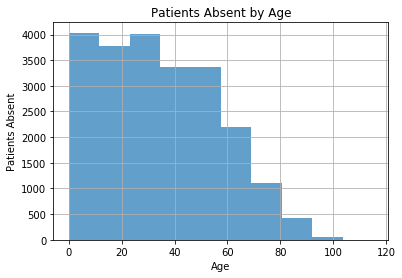

In [14]:
#plot bars
df.age[absent].hist(alpha =0.7)

#labels
plt.xlabel('Age')
plt.ylabel('Patients Absent')
plt.title('Patients Absent by Age');

In [15]:
df.age[absent].describe()

count    22319.000000
mean        34.317667
std         21.965941
min          0.000000
25%         16.000000
50%         33.000000
75%         51.000000
max        115.000000
Name: age, dtype: float64

>A basic histogram of the number of absent patients is arguably not very useful. While the mean and standard deviation are observable they do not really represent a sample likelihood of absenteeism. This is because the number of observations within age varies greatly, especially at the latter extreme of the sample since senior citizens are typically fewer. Instead, a graph of proportions may better capture the likelihood of absence.

In [16]:
#counting number of absent patients per age
age_counts = df.groupby(['no_show', 'age']).count()['gender']
#counting number of patients in total per age
age_totals = df.groupby(['age']).count()['gender']
#dividing absent patients by total number of patients per age
age_proportions = age_counts[1]/age_totals
age_proportions.dropna(inplace = True)

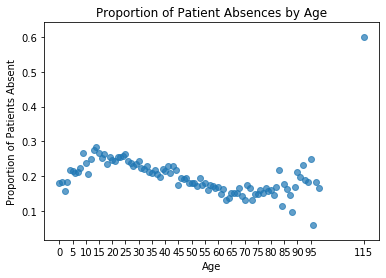

In [17]:
#plot bars
plt.scatter(age_proportions.index, age_proportions, alpha = .7, label = 'Age Proportions')

#labels
plt.xlabel('Age')
plt.ylabel('Proportion of Patients Absent')
plt.title('Proportion of Patient Absences by Age')
plt.xticks([x for x in age_proportions.index if x%5 ==0]);

In [18]:
age_proportions.describe()

count    100.000000
mean       0.198505
std        0.058913
min        0.058824
25%        0.164364
50%        0.192376
75%        0.228940
max        0.600000
Name: gender, dtype: float64

>Using proportions a much different pattern emerges. By this graph, absenteeism seems to decrease in prominence as a person becomes older. Indeed, the most likely to be absent are those within a rough 10-30 year-old bracket. Although there are a number of possible reasons, one hypothesis for this bracket of ages is that this age tends to be the healthiest, and therefore would place a low priority on seeking medical attention.

>Looking at the mean and standard deviation, it would seem that the likelihood for absenteeism is around 20%, with a 5% variation depending on age that is positive for younger individuals and negative for older individuals.

>In this sample metrics for the older individuals are difficult to observe since the sample is small, making absenteeism proportions quite exaggerated; this is especially apparent with the oldest age(115) where 3/5 individuals were absent, explaining the 60% absenteeism rate. That observation possibly exaggerates the standard deviation, but since it is only one observation it seems reasonable to include it. 

### Life Stages

>An alternative form of understanding the age characteristic is through a graph of general age groups (life stages). While this does remove the ability to emphasize the rate at which absenteeism develops over age, it does provide more clear-cut answers on which age group is more likely to be absent. Again, proportions will most likely provide better metrics than absolute numbers due to the difference in sample sizes

In [19]:
#counting number of absent patients per lifestage
# (0: Patient showed up. 1: Patient was absent)
ls_counts = df.groupby(['life_stage', 'no_show']).count()['gender']
#counting number of patients in total per lifestage
ls_totals = df.groupby(['life_stage']).count()['gender']
#dividing absent patients by total number of patients per lifestage
ls_proportions = ls_counts[1]/ls_totals
print(ls_proportions)

life_stage
Child          0.208230
Teenager       0.474817
Young Adult    0.217915
Adult          0.104247
Senior         0.346590
Name: gender, dtype: float64


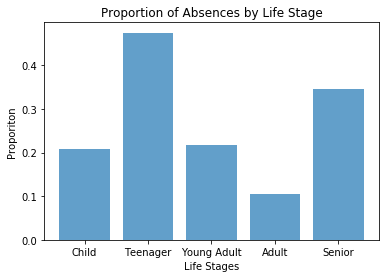

In [20]:
#plot bars
ind = np.arange(len(ls_proportions))
plt.bar(ind, ls_proportions, alpha = .7)

#labels
plt.ylabel('Proporiton')
plt.xlabel('Life Stages')
plt.title('Proportion of Absences by Life Stage')
labels = ['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']  # xtick labels
plt.xticks(ind, labels);

In [21]:
print(ls_proportions.describe())

count    5.000000
mean     0.270360
std      0.143019
min      0.104247
25%      0.208230
50%      0.217915
75%      0.346590
max      0.474817
Name: gender, dtype: float64


>When graphed by lifestages it becomes even more apparent that the youth are the most likely to demonstrate patient absenteeism. The age bins for life stages are as follows: Child(-1-12), Teenager (13-20), Young Adult (20-35), Adult(35-65), Senior (65+). Unlike the unbinned metric, observing absences by proportions does not create a very smooth curve. The standard deviation varies much more, +/- 14%, and the mean is much higher. This makes binning less useful for observing an overall level of absenteeism in the sample population. However, although this graph simplifies the issue and is strongly dictated by the bin edges, it provides straightforward and tangible answers on the primary age demographic for patient absenteeism; Teenagers are the most likely to be absent at 47% absences, and Adults are the least likely at 10%. This reconfirms the earlier analysis that younger people are more likely to be absent than older people. Interestingly, Seniors are also likely to be absent at 34% (possibly affected by outliers), and possible reasons could be generational stigma or forgetfulness.

### Research Question 2 : Are certain appointment days more likely to encourage patient absenteeism?

>This research question stems from the assumption that certain days, or even seasons, are more inclined to promote patient absenteeism. One could expect that summer seasons or even weekends would promote patient abseentism in preference for leisure. Or the opposite could be true that patients demonstrate absenteeism during busy work/school seasons. This analysis will not be able to conclude by which reasons patients demonstrate absenteeism but only which seasons/days were most suspect. All days are drawn from the year 2016, as noted by the dataset.

In [22]:
#get total counts for patient absenteeism for each day
# (0: Patient showed up. 1: Patient was absent)
appt_counts = df.groupby(['no_show', 'appt_trim']).count()['gender']
# get objects for graphing proportions
appt_total = df.groupby(['appt_trim']).count()['gender']
appt_prop = appt_counts/appt_total
print(appt_prop[1].index.shape)

(27,)


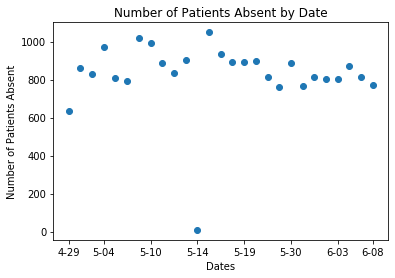

In [23]:
#plot graph
ind = np.arange(len(df['appt_trim'].unique()))
plt.scatter(list(df['appt_trim'].unique()), appt_counts[1])

#labels
plt.ylabel('Number of Patients Absent')
plt.xlabel('Dates')
plt.title('Number of Patients Absent by Date')

#getting x ticks
z = []
y = list(df['appt_trim'].unique())

for x in range(len(y)): #dates (MM-DD)
    z += [int(str(y[x]).replace('-', ''))]
z = np.sort(z)
for j in range(len(z)):
    y[j] = str(z[j])
    y[j] = str(y[j][0]) + '-' + str(y[j][1:]) 
plt.xticks([0, 3, 7, 11, 15, 19, 23, 26], [y[0], y[3], y[7], y[11], y[15], y[19], y[23], y[26]]);

>This graph demonstrates a very rough concave curve of absenteeism that peaks at around the middle of May. However, such a graph does not take into account the popularity of each day for scheduling. It is likely that some dates are more popular and would therefore end with a higher overall number of absences (or less, hence the May 14th observation). A graph of the proportional number of absences may possibly present a different conclusion.

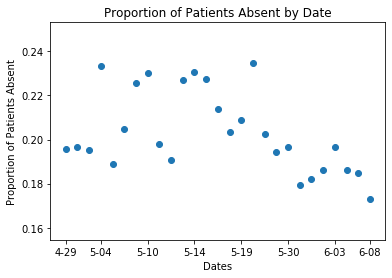

In [24]:
ind = np.arange(len(df['appt_trim'].unique()))
#plotting graph
plt.scatter(list(appt_prop[1].index), appt_prop[1])
plt.ylabel('Proportion of Patients Absent')
plt.xlabel('Dates')
plt.title('Proportion of Patients Absent by Date')

#labels
#Borrowing code from previous cell since xticks should be the same
z = []
y = list(df['appt_trim'].unique())

for x in range(len(y)): #dates (MM-DD)
    z += [int(str(y[x]).replace('-', ''))]
z = np.sort(z)
for j in range(len(z)):
    y[j] = str(z[j])
    y[j] = str(y[j][0]) + '-' + str(y[j][1:]) 
plt.xticks([0, 3, 7, 11, 15, 19, 23, 26], [y[0], y[3], y[7], y[11], y[15], y[19], y[23], y[26]]);

In [25]:
print(appt_prop[1].describe())

count    27.000000
mean      0.203189
std       0.018402
min       0.172806
25%       0.189674
50%       0.196822
75%       0.219652
max       0.234848
Name: gender, dtype: float64


>Graphed by proportions the data presents a very different story. By the graph there is a slight downward curve as the date proceeds towards June. However, the curve is no longer as apparrent around the middle of May as it was in the graph of absolute numbers. Moreover, a describe() function reveals that the standard deviation for the data on absences by dates is only around 2%. This would mean that the overall variation in likelihood of absence is quite little and that the general likelihood for absences is probably not too far from the mean of 20%. It would seem that the appointment date does not have a very strong impact on the likelihood for absences.

## Research Question: Does gender influence a patients likelihood to demonstrate patient absenteeism?

>This question stems from an assumption that men and women are raised/born differently, at least in a Brazil, and would show a significant difference in patient absenteeism.

In [26]:
# get total counts for patient absenteeism for each day
# (0: Patient is male. 1: Patient is female)
# (0: Patient showed up. 1: Patient was absent)
gender_counts = df.groupby(['no_show', 'gender']).count()['age'][1]
# objects for gender proportions
gender_totals = df.groupby(['gender']).count()['age']
gender_props = gender_counts/gender_totals

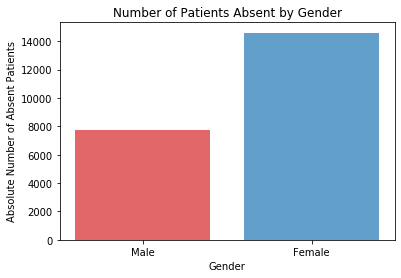

In [27]:
#plot bars
ind = np.arange(len(gender_counts))
plt.bar(ind, gender_counts, color = ['C3', 'C0'], alpha = .7)

#labels
plt.xlabel('Gender')
plt.ylabel('Absolute Number of Absent Patients')
plt.title('Number of Patients Absent by Gender')
plt.xticks([0, 1], ['Male', 'Female']);

>Although it would seem that Females are much more likely to demonstrate patient absenteeism, like in previous sections, the gender graph may better be understood through graphing proportions.

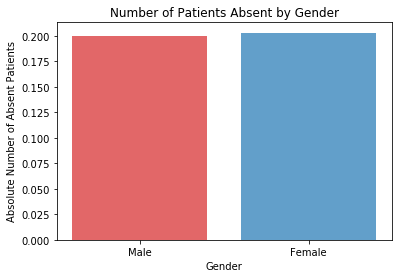

In [28]:
#plot bars
ind = np.arange(len(gender_props))
plt.bar(ind, gender_props, color = ['C3', 'C0'], alpha = .7)

#labels
plt.xlabel('Gender')
plt.ylabel('Absolute Number of Absent Patients')
plt.title('Number of Patients Absent by Gender')
plt.xticks([0, 1], ['Male', 'Female']);

In [29]:
print(gender_props.describe())

count    2.000000
mean     0.201413
std      0.002451
min      0.199679
25%      0.200546
50%      0.201413
75%      0.202279
max      0.203146
Name: age, dtype: float64


>When done by proportions this graph surprisingly takes a turn that resembles the appointment day characteristic. Even smoother than before, absenteeism graphed by gender proportions is even more uniform, with both Males and Females demonstrating about 20% likelihood for absenteeism with a .2% standard deviation. This strongly suggests that gender does not influence likelihood for absenteeism.

## Gender and Age

>This investigation gives further insight into the question of gender and age by assuming that there may be variations in patient absenteeism that are influenced by the two variables interacting with each other.

>Due to limitations of a purely graphical analysis, the graph will be using lifestage as this may improve readability.

In [30]:
# Retrieving all absent counts for gender and age
ga_counts = df.groupby(['no_show', 'gender', 'life_stage',]).count()['appointmentday'][1]
# Retrieving objects for proportions of absences for gender and age
ga_totals = df.groupby(['gender', 'life_stage']).count()['appointmentday']
ga_props = ga_counts/ga_totals
ga_props[0]

life_stage
Child          0.207096
Teenager       0.269987
Young Adult    0.232087
Adult          0.178983
Senior         0.152721
Name: appointmentday, dtype: float64

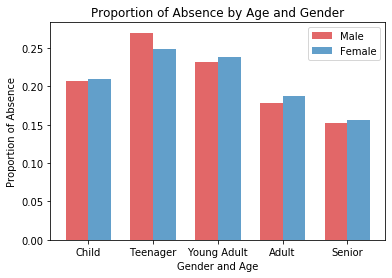

In [43]:
#plot bars
ind = np.arange(len(ga_props)/2)
width = 0.35
male_bars = plt.bar(ind, ga_props[0], width, color = 'C3', alpha = .7, label = 'Male')
white_bars = plt.bar(ind + width, ga_props[1], width, color = 'C0', alpha = .7, label = 'Female')

#labels
plt.xlabel('Gender and Age')
plt.ylabel('Proportion of Absence')
plt.title('Proportion of Absence by Age and Gender')
plt.legend()
plt.xticks(ind + width/2, labels = ['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']);

In [46]:
print('Male')
print(ga_props[0].describe())
print()
print('Female')
print(ga_props[1].describe())

Male
count    5.000000
mean     0.208175
std      0.045610
min      0.152721
25%      0.178983
50%      0.207096
75%      0.232087
max      0.269987
Name: appointmentday, dtype: float64

Female
count    5.000000
mean     0.208088
std      0.037794
min      0.156604
25%      0.186828
50%      0.209467
75%      0.238191
max      0.249352
Name: appointmentday, dtype: float64


> As before the age bins are as follows: Child(-1-12), Teenager (13-20), Young Adult (20-35), Adult(35-65), Senior (65+).

> In this graph of absenteeism proportions by age and gender, it seems that there is still very little variation in absenteeism by gender. Although females tended to be slightly more prone to absenteeism than males, except for Teenagers, this fact is arguably nelgibile. The overall differences in means between males and females is only a difference of .000097; in other words, females are on average more likely to be absent by .0097%, an arguably insiginficant statistic. However, it should be noted that age seems to still be a strong determinant in variation of absences, and moreover the average likelihood for absence remains more or less the same as both the previous analysis of aggregate gender and age, 20%.

<a id='conclusions'></a>
## Conclusions

> Of the characteristics analyzed, age, appointment date, and gender, it would seem that the most significant determinant in variation of absenteeism is age. Above all, the overall likelihood of absenteeism seems to be roughly 20%, gathered from all three characteristics, with much less variation than initially assumed.

> Nonetheless, this analysis is still exceptionally rudimentary. As stated in the Introduction, this analyses fails to take a number of characteristics into account, such as Culture or even Neighbourhood. Further analysis on such characteristics, such as Neighbourhood, might reveal a region that has exceptionally high rates of absenteeism, or vice versa, that do not vary with age or gender. 

>Also, as mentioned in the appointment day analysis, the data analyzed here was cross-sectional and has limited ability to make statements about Brazil as a whole. While 2016 may demonstrate a supposed 20% rate of abseenteeism, this may not be the case for other years.

>Lastly, this analysis has no plausibile explanations for the variations observed in the analysis. Although variations are observed in age, appointment day, and gender (however slight), no reasons for these variations cannot be provided, only conjecture.